In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from os import chdir

In [2]:
chdir('/home/pirl/opencv/SangWoo_Lab/LP_image/real_data')
os.getcwd()

'/home/pirl/opencv/SangWoo_Lab/LP_image/real_data'

# Load rotated image

In [24]:
img_color = cv2.imread('/home/pirl/opencv/SangWoo_Lab/nogada/lp3_results/rotated_0213271500526.jpg')

# cv2.imshow('img_color', img_color)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# shape 구하기
print(img_color.shape)

(40, 100, 3)


In [25]:
height, width, channel = img_color.shape

(<matplotlib.image.AxesImage at 0x7fbc40a2e940>,
 Text(0.5, 1.0, 'Gray Scale image'))

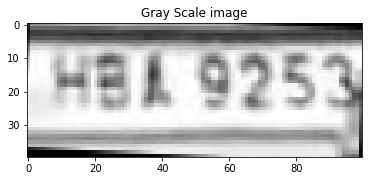

In [26]:
img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

plt.imshow(img_gray, 'gray'), plt.title('Gray Scale image')

(<matplotlib.image.AxesImage at 0x7fbc40a14630>,
 Text(0.5, 1.0, 'Adaptive Threshold'))

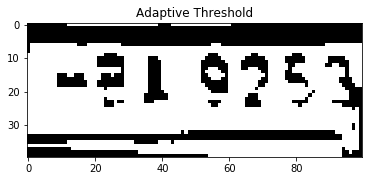

In [27]:
_, thr1 = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

plt.imshow(thr1, 'gray'), plt.title('Adaptive Threshold')

(<matplotlib.image.AxesImage at 0x7fbc40b3e9e8>,
 Text(0.5, 1.0, 'Gray Scale image'))

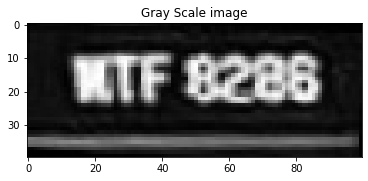

In [21]:
img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

plt.imshow(img_gray, 'gray'), plt.title('Gray Scale image')

(<matplotlib.image.AxesImage at 0x7fbc40b10cc0>,
 Text(0.5, 1.0, 'Adaptive Threshold'))

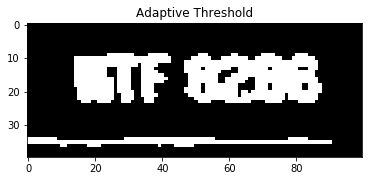

In [22]:
_, thr1 = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

plt.imshow(thr1, 'gray'), plt.title('Adaptive Threshold')

# Contours

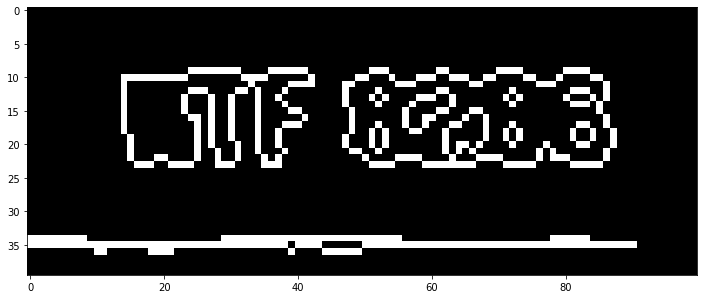

In [23]:
contours, hierarchy = cv2.findContours(thr1, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)

# Contours 를 기준으로 사각형 영역 검출

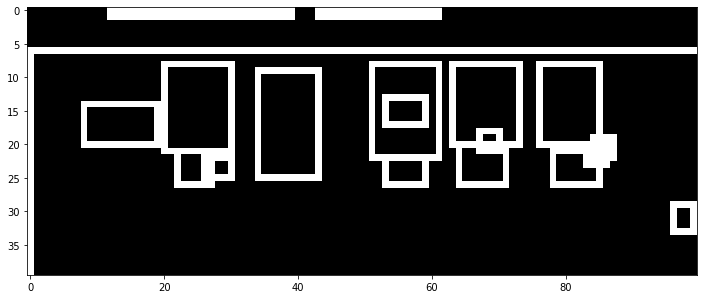

In [14]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=1)
    
    # insert to dict
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })

# 중심점 찾으려고 만들긴함...    
# for contour in contours:

#     M = cv2.moments(contour)

#     cx = int(M['m10']/M['m00'])
#     cy = int(M['m01']/M['m00'])

#     cv2.circle(img_color, (cx, cy), 10, (0,0,255), -1)

  
    
    
    
plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

# 사각형 영역의 최소값, 최대값, 가로 세로 비율 등등 지정

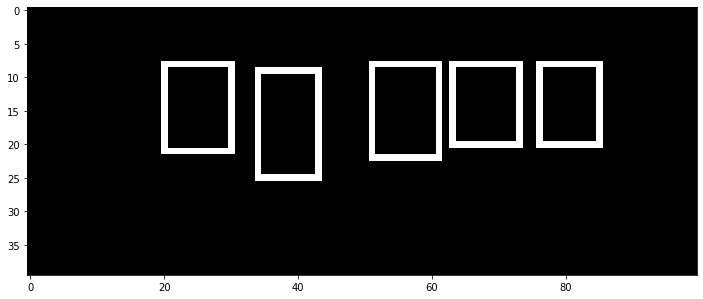

In [15]:
MIN_AREA = 100
MAX_AREA = 2000
# MIN_WIDTH, MIN_HEIGHT = 2, 8
MIN_RATIO, MAX_RATIO = 1.0, 2.0

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
#     if area > MIN_AREA and area < MAX_AREA \
#     and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
#     and MIN_RATIO < ratio < MAX_RATIO:
#         d['idx'] = cnt
#         cnt += 1
#         possible_contours.append(d)
        
# 가로,세로, 넓이 비율 삭제
    if area > MIN_AREA and area < MAX_AREA:
        #and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)
        
# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
#     cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
    temp_result = cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']),\
                                color=(255, 255, 255), thickness=1)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

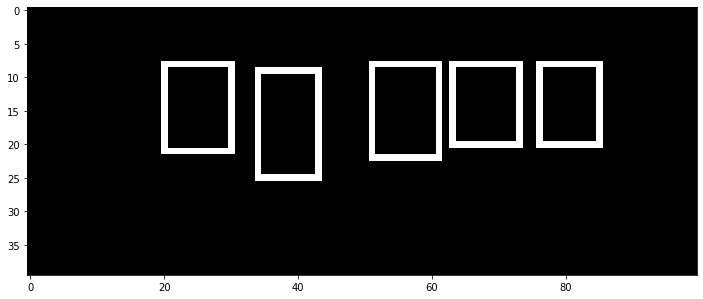

In [16]:
MAX_DIAG_MULTIPLYER = 5 # 5
MAX_ANGLE_DIFF = 50.0 # 12.0
MAX_AREA_DIFF = 3 # 0.5
MAX_WIDTH_DIFF = 2
MAX_HEIGHT_DIFF = 0.5
MIN_N_MATCHED = 2 # 3

def find_chars(contour_list):
    matched_result_idx = []
    
    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue

            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)

            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])

        # append this contour
        matched_contours_idx.append(d1['idx'])

        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue

        matched_result_idx.append(matched_contours_idx)

        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        # recursive
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break

    return matched_result_idx
    
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
#         cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        temp_result = cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']),\
                                     color=(255, 255, 255), thickness=1)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

# Rotate Image

-0.5161642297648366


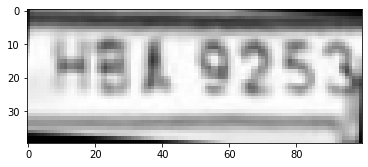

In [17]:
PLATE_WIDTH_PADDING = 1.3 # 1.3
PLATE_HEIGHT_PADDING = 1.5 # 1.5
MIN_PLATE_RATIO = 1
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
    print(angle)
    
    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
    
    img_rotated = cv2.warpAffine(img_gray, M=rotation_matrix, dsize=(width, height))
    
#     img_cropped = cv2.getRectSubPix(
#         img_rotated, 
#         patchSize=(int(plate_width), int(plate_height)), 
#         center=(int(plate_cx), int(plate_cy))
#     )
    
#     if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
#         continue
    
#     plate_imgs.append(img_cropped)
#     plate_infos.append({
#         'x': int(plate_cx - plate_width / 2),
#         'y': int(plate_cy - plate_height / 2),
#         'w': int(plate_width),
#         'h': int(plate_height)
#     })
    
    plt.subplot(len(matched_result), 1, i+1)
    plt.imshow(img_rotated, cmap='gray')

In [18]:
_, thr1 = cv2.threshold(img_cropped, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

plt.imshow(thr1, 'gray'), plt.title('Adaptive Threshold')

NameError: name 'img_cropped' is not defined

(<matplotlib.image.AxesImage at 0x7fb611c94748>,
 Text(0.5, 1.0, 'Adaptive Threshold'))

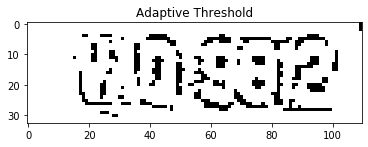

In [159]:
th3 = cv2.adaptiveThreshold(img_cropped,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
cv2.THRESH_BINARY,15,2)

plt.imshow(dst, 'gray'), plt.title('Adaptive Threshold')

# Rotate plate img

In [15]:
contours, hierarchy = cv2.findContours(temp_result, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours:

    M = cv2.moments(cnt)

    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])

    cv.circle(img_color, (cx, cy), 10, (0,0,255), -1)

cv2.imshow("result", img_color)

cv2.waitKey(0)

error: OpenCV(4.1.1) /io/opencv/modules/imgproc/src/contours.cpp:197: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


# 여기까지 위에까지 작업 

# 아래부터는 혼자 찌끄린거

In [ ]:
from os import walk
test_path = "/home/pirl/opencv/SangWoo_Lab/LP_image/must_be_lttd"

files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(test_path):
    for file in f:
        if '.jpg' or '.jpeg' or '.gif' or '.png' or '.pgm' in file:
            files.append(os.path.join(r, file))

In [ ]:
files

In [ ]:
sizes = []
for i in range(len(files)):
    img_color = cv2.imread(files[i])
    height, width, channel = img_color.shape
    sizes.append(img_color.shape)
    


In [ ]:
sizes

In [ ]:
def img_shape(input_img):
    height, width, channel = input_img.shape

    return height, width, channel

In [ ]:
def resize_img(input_img):
    height = 300
    width = 300
    dim = (width, height)
    resized_image = cv2.resize(input_img, dim, interpolation=cv2.INTER_AREA)
    print('Resized Dimensions : ', resized_image.shape)

    return resized_image

In [ ]:
# files 안에 파일 이름 넣기

from os import walk
test_path = "/home/pirl/opencv/SangWoo_Lab/LP_image/real_data"

files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(test_path):
    for file in f:
        if '.jpg' or '.jpeg' or '.gif' or '.png' or '.pgm' in file:
            files.append(os.path.join(r, file))

In [ ]:
files

In [ ]:
sizes = []
good_size = (300, 300, 3)
for i in range(len(files)):
    img_color = cv2.imread(files[i])
    height, width, channel = img_color.shape
    print(img_color.shape)
    if img_color.shape != good_size:
        print(files[i],'사이즈가 안 맞잖아!')
    else:
        print(files[i],'맞잖아!')
        
    sizes.append(img_color.shape)

In [ ]:
 for i, name in enumerate(['body', 'foo', 'bar']):
...     print(i, name)

In [ ]:
for k, i in enumerate(files):
    img_color = cv2.imread(i)
    h, w, c = img_shape(img_color)

    # shape must be (300,300,3)
    good_size = (300, 300, 3)
    if img_color.shape != good_size:
        print('원래 이미지 사이즈' + str(img_color.shape))
        img_color = resize_img(img_color)
    else:
        print('올바른 size')
        
    print(str(k+1) + '번째 끝')
        
    print(img_color.shape)
        
    

In [ ]:
sizes = []
good_size = (300, 300, 3)
for i in range(len(files)):
    img_color = cv2.imread(files[i])
    height, width, channel = img_color.shape
    print(img_color.shape)
    if img_color.shape != good_size:
        print('사이즈가 안 맞잖아!')
    else:
        print('맞잖아!')
        
    sizes.append(img_color.shape)